In [1]:
import pde
import matplotlib.pyplot as plt
import numpy as np

## Model
$$ \partial_t T= \alpha \partial_x^2T +qr-h$$ $$\partial_t c = D \partial_x^2 c -r+e$$
$$ r(T,c) = \begin{array}{cc}
  \Bigg \{ & 
    \begin{array}{cc}
      A ,& T>T_{\mathrm{ig}} \wedge c>c_{\mathrm{LFL}} \\
      0 ,& \mathrm{otherwise} \\
    \end{array}
\end{array}$$
$$ h(T) =C_1(T-T_0)$$
$$ e(T,c) = C_2(c_0-c)$$

In [2]:
def A(x, A0, Ea, a, b):
    R = 1.987
    o2 = 8.8e-6
    rez = A0*np.exp(-Ea/(1.987*x[:,0]))*(x[:,1]**a)*(o2**b)
    return np.array([rez,rez]).T

In [3]:
def alpha(x): #thermal diffusivity
    return alpha0
def D(x): #mass diffusivity
    return D0
def r(T,c): #stopa reakcije
    x = np.array([T,c]).T
    return np.piecewise(x, [np.logical_and(x[:,0] > 0, x[:,1] > cLFL)], [A,0], A0,Ea,a,b)[:,0]
def h(T): #heat loss
    return C1*(T-T0)
def e(T,c): #isparavanje + gubitci 
    return (c0-c)*C2
def q(x):
    return qc/rho/cp
def upaljac(x,t):
    #return 0 
    if t>0.4: return 0
    return 2000*np.exp(-(x-l/2)**2/0.01)

In [4]:
#default vrijednosti konstanti (etanol,zrak)

Tig = 636 #K

A0 = 1.5e12
Ea = 30000 #cal/mol
a = 0.15
b = 1.6

H = 0.5#cm
C1 = 1.5/H #1/s
D0 = 0.17 #cm^2/s
C2 = D0/(2*H/5)**2 #(D0 = difuzijska konstanta etanola, h = visina plamena u cm)

T0 = 300 #K
c0 = 1.4e-6#mol/cc
qc = 1336.8e3 #J/mol
rho = 0.5e-3 #g/cc
cp = 1 #J/gK
cLFL = 1.2e-6

alpha0 = 0.23 #cm^2/s

In [5]:
#integracija jednadzbi
def ign(l=3,w=0.3,Tmax=650,tr=0.01,N=150,dt=1e-8,dt_t=1e-6, tf = 0.1, S=13000):
    def upaljac(x,t):
        #return 0 
        if t>tf: return 0
        return S*np.exp(-(x-l/2)**2/0.01)
    grid = pde.CartesianGrid([[0,l]],N,periodic=True) #inicijalizacija domene
    
    pobuda = pde.ScalarField.from_expression(grid, f'{Tmax}*(Heaviside(x-{l/2}+{w/2})-Heaviside(x-{l/2}-{w/2}))')
    #pobudaC = pde.ScalarField.from_expression(grid, f'-(Heaviside(x-{l}+{w})-Heaviside(x-5))')

    Tinit = pde.ScalarField(grid, T0) + pobuda #pocetna temperatura
    cinit = pde.ScalarField(grid, c0) #pocetna koncentracija
    init = pde.FieldCollection([Tinit,cinit])
    
    #definicija sustava
    eq = pde.PDE({'T':"a(x)*laplace(T)+q(x)*r(T,c)-h(T) + s(x,t)", 'c': "D(x)*laplace(c)-r(T,c)+e(T,c)"},user_funcs={'a': alpha, 'r': r, 'h': h, 'D':D, 'e':e, 'q':q, 's':upaljac})
    
    storage=pde.MemoryStorage()
    result=eq.solve(init, t_range=tr,dt =dt, tracker=[storage.tracker(dt_t)], backend="numpy")

    return (result,storage)

In [6]:
#plotaj
def plotall(result,storage, filename=""):
    if filename=="":
        pde.plot_kymograph(storage.extract_field(0),title="T/K")
        pde.plot_kymograph(storage.extract_field(1),title="c/(mol/cc)")
        result[0].plot(ax_style={'ylabel':'T/K'})
        result[1].plot(ax_style={'ylabel':'c/(mol/cc)'})
    else:
        pde.plot_kymograph(storage.extract_field(0),title="T/K", filename=filename+"T.png")
        pde.plot_kymograph(storage.extract_field(1),title="c/(mol/cc)",filename=filename+"c.png")
        result[0].plot(ax_style={'ylabel':'T/K'}, filename=filename+"Tf.png")
        result[1].plot(ax_style={'ylabel':'c/(mol/cc)'},filename=filename+"cf.png")

In [7]:
#procjena ocekivane brzine
def v(dc):
    Tavg = (T0+qc*dc/rho/cp)/2
    return np.sqrt(alpha0*A(np.array([[1000,(c0+cLFL)/2]]),A0,Ea,a,b)[0][0]/dc*(qc*dc/rho/cp/(Tig-T0)-1))

In [47]:
#da bi se dobile kolko tolko smislene stvari korak dt mora biti jako mali (1e-8 za doljnje vrijednosti parametara)

In [45]:
C1= 25
c0= 2e-6
result,storage = ign(tr=0.06,dt=1e-7,dt_t=1e-5,Tmax=490, tf = 0.02, S=0, N=200)

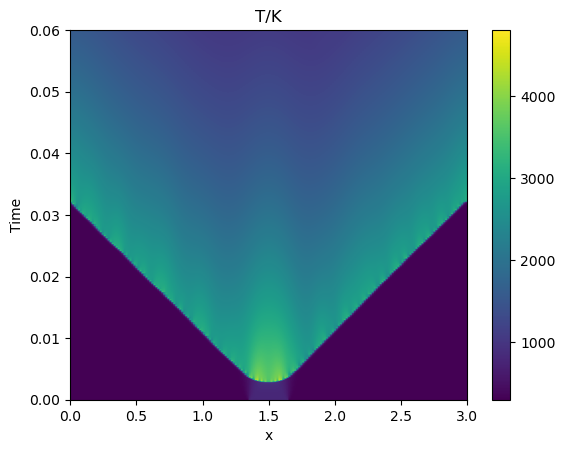

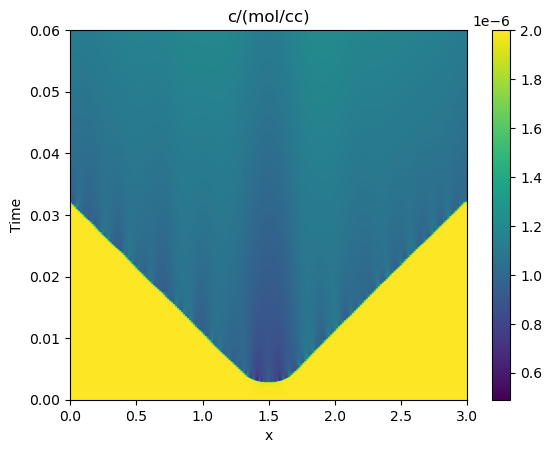

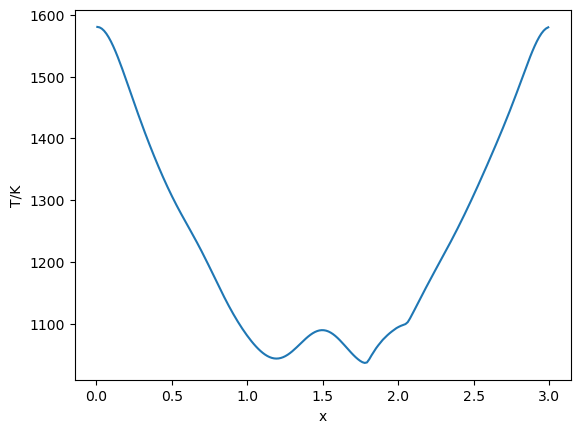

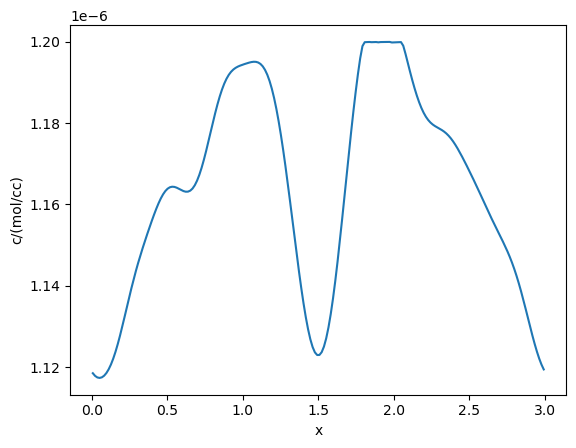

In [46]:
plotall(result,storage)

In [10]:
#pde.movie(storage,filename=f"m1-20.mp4")